In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* CAD/JPY exchange rate returns. 

In [2]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [3]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


In [4]:
cad_jpy_df_2 = cad_jpy_df
cad_jpy_df_2['Percentage Returns'] = cad_jpy_df_2['Price'].pct_change() * 100
cad_jpy_df_2

,Price,Open,High,Low,Percentage Returns
Date,,,,,
1990-01-02,126.37,126.31,126.37,126.31,NaN
1990-01-03,125.30,125.24,125.30,125.24,-0.846720
1990-01-04,123.46,123.41,123.46,123.41,-1.468476
1990-01-05,124.54,124.48,124.54,124.48,0.874777
1990-01-08,124.27,124.21,124.27,124.21,-0.216798
...,...,...,...,...,...
2020-05-29,78.29,78.21,78.41,77.75,0.076697
2020-06-01,79.27,78.21,79.36,78.04,1.251756
2020-06-02,80.40,79.26,80.56,79.15,1.425508


# Data Preparation

### Returns

In [5]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
# YOUR CODE HERE!

cad_jpy_df['Returns'] = cad_jpy_df['Price'].pct_change() * 100
# del cad_jpy_df['Return']
cad_jpy_df = cad_jpy_df.dropna()
cad_jpy_df.head()

,Price,Open,High,Low,Percentage Returns,Returns
Date,,,,,,
1990-01-03,125.30,125.24,125.30,125.24,-0.846720,-0.846720
1990-01-04,123.46,123.41,123.46,123.41,-1.468476,-1.468476
1990-01-05,124.54,124.48,124.54,124.48,0.874777,0.874777
1990-01-08,124.27,124.21,124.27,124.21,-0.216798,-0.216798
1990-01-09,125.10,125.04,125.10,125.04,0.667901,0.667901


# Double check with someone ^^

### Lagged Returns 

In [6]:
# Create a lagged return using the shift function
# YOUR CODE HERE!
cad_jpy_df['Lagged_Returns'] = cad_jpy_df['Returns'].shift()
# Drop NaN values
cad_jpy_df = cad_jpy_df.dropna()
cad_jpy_df

<ipython-input-6-359248849ea3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cad_jpy_df['Lagged_Returns'] = cad_jpy_df['Returns'].shift()


,Price,Open,High,Low,Percentage Returns,Returns,Lagged_Returns
Date,,,,,,,
1990-01-04,123.46,123.41,123.46,123.41,-1.468476,-1.468476,-0.846720
1990-01-05,124.54,124.48,124.54,124.48,0.874777,0.874777,-1.468476
1990-01-08,124.27,124.21,124.27,124.21,-0.216798,-0.216798,0.874777
1990-01-09,125.10,125.04,125.10,125.04,0.667901,0.667901,-0.216798
1990-01-10,125.81,125.75,125.81,125.75,0.567546,0.567546,0.667901
...,...,...,...,...,...,...,...
2020-05-29,78.29,78.21,78.41,77.75,0.076697,0.076697,-0.114913
2020-06-01,79.27,78.21,79.36,78.04,1.251756,1.251756,0.076697
2020-06-02,80.40,79.26,80.56,79.15,1.425508,1.425508,1.251756


### Train Test Split

In [7]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train_ = cad_jpy_df[:'2017']
test_ = cad_jpy_df['2018':'2019']

In [8]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
# YOUR CODE HERE!

Y_train_ = pd.DataFrame(train_).Lagged_Returns
Y_test_ = pd.DataFrame(test_).Lagged_Returns 

X_train_ = pd.DataFrame(train_).drop(columns = 'Lagged_Returns')
X_test_ = pd.DataFrame(test_).drop(columns ='Lagged_Returns')


In [9]:
# Preview the X_train data
# YOUR CODE HERE!
X_train_.head()

,Price,Open,High,Low,Percentage Returns,Returns
Date,,,,,,
1990-01-04,123.46,123.41,123.46,123.41,-1.468476,-1.468476
1990-01-05,124.54,124.48,124.54,124.48,0.874777,0.874777
1990-01-08,124.27,124.21,124.27,124.21,-0.216798,-0.216798
1990-01-09,125.10,125.04,125.10,125.04,0.667901,0.667901
1990-01-10,125.81,125.75,125.81,125.75,0.567546,0.567546


# Check to see if it's correct

# Linear Regression Model

In [10]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using  just the training set (X_train, Y_train):
# YOUR CODE HERE!
model = LinearRegression()
model.fit(X_train_ , Y_train_)

LinearRegression()

# Make predictions using the Testing Data

**Note:** We want to evaluate the model using data that it has never seen before, in this case: `X_test`.

In [11]:
# Make a prediction of "y" values using just the test dataset
# YOUR CODE HERE!'
predictions = model.predict(X_test_)
predictions[1]

0.10341770520331839

In [12]:
Results = Y_test_.to_frame()
Results["Predicted Return"] = predictions

In [13]:
Results

,Lagged_Returns,Predicted Return
Date,,
2018-01-01,-0.256096,0.145449
2018-01-02,0.245591,0.103418
2018-01-03,-0.055679,0.147264
2018-01-04,0.011142,0.059732
2018-01-05,0.601604,-0.086310
...,...,...
2019-12-25,-0.156212,0.116326
2019-12-26,0.000000,0.054667
2019-12-27,0.553617,0.117424


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

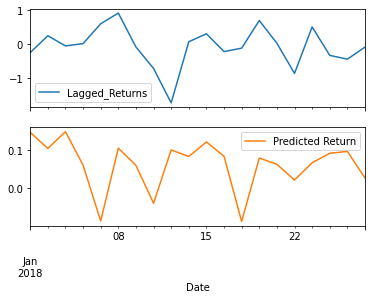

In [14]:
# Plot the first 20 predictions vs the true values
# YOUR CODE HERE!
Results[:20].plot(subplots=True)

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (`X_test` and `y_test`)

In [15]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
# (Hint: use the dataframe from above)
# YOUR CODE HERE!
out_mse = mean_squared_error(Y_test_, predictions)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
# YOUR CODE HERE!
out_rmse = np.sqrt(out_mse)

print(f'MSE : {out_mse}')
print(f'RMSE : {out_rmse}')

MSE : 0.2781785451893924
RMSE : 0.5274263410082894


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [16]:
# Construct a dataframe using just the "Y" training data:
# YOUR CODE HERE!
in_sample_data_ = Y_train_.to_frame()


# Add a column of "in-sample" predictions to that dataframe:  
# YOUR CODE HERE!
in_sample_data_["in-sample_Predictions"] = model.predict(X_train_)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
# YOUR CODE HERE!

in_mse = mean_squared_error(in_sample_data_["Lagged_Returns"],
                           in_sample_data_["in-sample_Predictions"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
# YOUR CODE HERE!
in_rmse = np.sqrt(in_mse)

print(f'MSE : {in_mse}')
print(f'RMSE : {in_rmse}')

MSE : 0.6964005699476761
RMSE : 0.8345061832890611


# Conclusions

**Question:** Does this model perform better or worse on out-of-sample data as compared to in-sample data?

**Answer:** The model performes considerbly better in-sample than out-sample